In [41]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, LearningRateScheduler

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, normalize
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

from utils import mod_df, drop_features, inverse_mod_X, inverse_mod_y, apply_savgol_filter, apply_median_filter, apply_maximum_filter, apply_is_zero
from my_model import create_model_1, create_model_1_1, create_model_1_2, create_model_1_3, create_model_2, create_model_2_1
tf.__version__

'2.6.0'

In [42]:
train_df = pd.read_csv(os.path.join('data', 'unionTrain.csv'))
test_df = pd.read_csv(os.path.join('data', 'unionTest.csv'))

In [43]:
X_train, y_train = mod_df(train_df)
X_test, y_test = mod_df(test_df)

In [44]:
def feature_engineering(df):
    result = df.copy()
    
    # drop features
    result = result.drop(['id', 'timestep'], axis=1)
    result = drop_features(result, [15, 16, 17, 18, 20, 21, 23, 24])
    
    # add features
    for col in result.columns.to_list():
        feature = result[col]
        feature = feature.to_numpy()
        # result[f'{col}_savgol'] = apply_savgol_filter(feature)
        # result[f'{col}_median'] = apply_median_filter(feature)
        # result[f'{col}_max'] = apply_maximum_filter(feature)
        result[f'{col}_sav_med'] = apply_median_filter(apply_savgol_filter(feature, window_size=21), window_size=5)
        result[f'{col}_is_zero'] = apply_is_zero(feature)
    
    # modify features
    for col in result.columns.to_list():
        feature = result[col]
        feature = feature.to_numpy()
        # result[col] = apply_savgol_filter(feature)
        # result[col] = apply_median_filter(feature)
        # result[col] = apply_maximum_filter(feature)
        # result[col] = apply_median_filter(apply_savgol_filter(feature))
     
    return result
X_train_1 = feature_engineering(X_train)
X_test_1 = feature_engineering(X_test)
# X_train_1[5:20]

,0X,0Y,1X,1Y,2X,2Y,3X,3Y,4X,4Y,...,12Y_sav_med,12Y_is_zero,13X_sav_med,13X_is_zero,13Y_sav_med,13Y_is_zero,14X_sav_med,14X_is_zero,14Y_sav_med,14Y_is_zero
0,203.818390,137.074432,213.271698,120.394463,218.456604,128.786789,214.281204,138.171570,209.073471,139.232819,...,114.064766,0.0,204.133666,0.0,114.495655,0.0,209.358724,0.0,114.205887,0.0
1,202.822815,137.111649,213.233521,121.473770,215.352936,130.859268,213.268051,138.193253,210.108292,145.416718,...,114.064766,0.0,204.320054,0.0,114.495655,0.0,209.587539,0.0,114.205887,0.0
2,203.875107,135.035492,213.195465,122.542183,215.313980,131.896347,213.288605,138.153976,210.126511,145.461868,...,114.064766,0.0,204.506442,0.0,114.495655,0.0,209.816353,0.0,114.205887,0.0
3,204.877747,139.191315,212.251190,124.581474,214.282669,133.981262,213.277390,145.446198,211.125778,146.475586,...,113.955958,0.0,204.692830,0.0,114.413395,0.0,210.045167,0.0,114.121115,0.0
4,203.836639,131.908508,214.268494,121.539581,218.434967,131.926605,215.344208,142.320038,211.121185,145.482742,...,113.847150,0.0,204.879218,0.0,114.331135,0.0,210.273982,0.0,114.036344,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91373,206.996933,138.201385,206.996933,138.201385,206.996933,138.201385,206.996933,138.201385,206.996933,138.201385,...,138.201385,0.0,206.996933,0.0,138.201385,0.0,206.996933,0.0,138.201385,0.0
91374,206.996933,138.201385,206.996933,138.201385,206.996933,138.201385,206.996933,138.201385,206.996933,138.201385,...,138.201385,0.0,206.996933,0.0,138.201385,0.0,206.996933,0.0,138.201385,0.0
91375,206.996933,138.201385,206.996933,138.201385,206.996933,138.201385,206.996933,138.201385,206.996933,138.201385,...,138.201385,0.0,206.996933,0.0,138.201385,0.0,206.996933,0.0,138.201385,0.0
91376,206.996933,138.201385,206.996933,138.201385,206.996933,138.201385,206.996933,138.201385,206.996933,138.201385,...,138.201385,0.0,206.996933,0.0,138.201385,0.0,206.996933,0.0,138.201385,0.0


In [45]:
tmp = X_train_1['0X'].value_counts()
tmp2 = np.array([tmp.index.to_numpy(), tmp.to_numpy()]).T
# tmp2[0:100, :]

In [46]:
def get_scaler(scaler_name='MinMaxScaler'):
    if scaler_name == 'RobustScaler':
        scaler = RobustScaler()
    elif scaler_name == 'MinMaxScaler':
        scaler = MinMaxScaler()
    return scaler
# scaler_name = 'RobustScaler'
scaler_name = 'MinMaxScaler'
scaler = get_scaler(scaler_name)

In [47]:
X_train_scaled = scaler.fit_transform(X_train_1)
X_test_scaled = scaler.transform(X_test_1)

X_train_scaled.shape

(91378, 90)

In [48]:
# joblib.dump(scaler, os.path.join('saved_scaler', f'{scaler_name}.pkl'))

In [49]:
X_train_modified, y_train_modified = inverse_mod_X(X_train_scaled), inverse_mod_y(y_train)
X_test_modified, y_test_modified = inverse_mod_X(X_test_scaled), inverse_mod_y(y_test)
print(X_train_modified.shape, y_train_modified.shape)

(107, 854, 90) (107, 2)


In [50]:
input_shape, n_output = (X_train_modified.shape[-2], X_train_modified.shape[-1]), y_train_modified.shape[1]
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_6 (Bidirection (None, 854, 64)           31488     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 854, 32)           10368     
_________________________________________________________________
bidirectional_8 (Bidirection (None, 32)                6272      
_________________________________________________________________
dense_4 (Dense)              (None, 25)                825       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 52        
Total params: 49,005
Trainable params: 49,005
Non-trainable params: 0
_________________________________________________________________


In [52]:
reduce_lr = ReduceLROnPlateau(
                                monitor='val_loss',
                                factor=0.5,
                                patience=4,
                                min_lr=1e-4
                              )
early_stopping = EarlyStopping(
                                monitor='loss',
                                patience=6
                              )

In [53]:
history = model.fit(X_train_modified, y_train_modified,
          batch_size=32,
          epochs=30,
          shuffle=True,
          validation_split=0.2,
          callbacks=[
              reduce_lr,
              early_stopping,
              ]
          )

Epoch 1/300
3/3 [==============================] - 17s 1s/step - loss: 0.6612 - accuracy: 0.5882 - val_loss: 0.6442 - val_accuracy: 0.6818
Epoch 2/300
3/3 [==============================] - 1s 203ms/step - loss: 0.5554 - accuracy: 0.6941 - val_loss: 0.6984 - val_accuracy: 0.6364
Epoch 3/300
3/3 [==============================] - 1s 194ms/step - loss: 0.5254 - accuracy: 0.7059 - val_loss: 0.6514 - val_accuracy: 0.6364
Epoch 4/300
3/3 [==============================] - 1s 204ms/step - loss: 0.5005 - accuracy: 0.7059 - val_loss: 0.6489 - val_accuracy: 0.7727
Epoch 5/300
3/3 [==============================] - 1s 208ms/step - loss: 0.4884 - accuracy: 0.7059 - val_loss: 0.6990 - val_accuracy: 0.7273
Epoch 6/300
3/3 [==============================] - 1s 197ms/step - loss: 0.4617 - accuracy: 0.7765 - val_loss: 0.7088 - val_accuracy: 0.7273
Epoch 7/300
3/3 [==============================] - 1s 210ms/step - loss: 0.4478 - accuracy: 0.7882 - val_loss: 0.6949 - val_accuracy: 0.6364
Epoch 8/300
3/3

In [54]:
# from datetime import datetime
# current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# model.save(os.path.join("saved_models", f"trained_at_{current_time}_using_{scaler_name}.h5"))

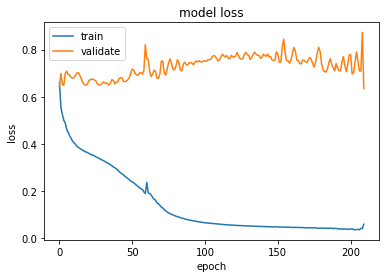

In [55]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

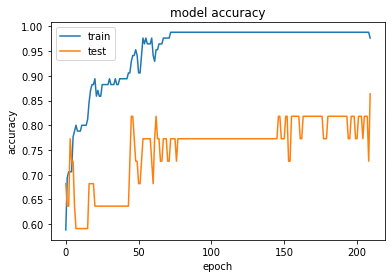

In [56]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [57]:
train_predict = model.predict(X_train_modified)
train_predict = np.argmax(train_predict, axis=1)+1
train_real = np.argmax(y_train_modified, axis=1)+1

# for i in range(len(y_train_modified)):
#     print(f"Index:{i}, Predict:{train_predict[i]}, Real:{train_real[i]}")

              precision    recall  f1-score   support

           1     0.9231    0.9412    0.9320        51
           2     0.9455    0.9286    0.9369        56

    accuracy                         0.9346       107
   macro avg     0.9343    0.9349    0.9345       107
weighted avg     0.9348    0.9346    0.9346       107

---------------------------------------------------------



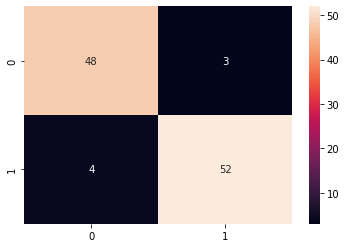

In [58]:
f1_train = f1_score(train_real, train_predict)
accuracy_train = accuracy_score(train_real, train_predict)
# print(f"f1: {f1_train:.4f}\naccuracy: {accuracy_train:.4f}")
print(classification_report(train_real, train_predict, digits=4))
print("---------------------------------------------------------")
sns.heatmap(confusion_matrix(train_real, train_predict),annot = True,fmt = '2.0f')
print()

In [59]:
test_predict = model.predict(X_test_modified)
test_predict = np.argmax(test_predict, axis=1)+1
test_real = np.argmax(y_test_modified, axis=1)+1

# for i in range(len(y_test)):
#     print(f"Index:{i}, Predict:{test_real[i]}, Real:{test_real[i]}")

              precision    recall  f1-score   support

           1     0.5000    0.6000    0.5455         5
           2     0.8462    0.7857    0.8148        14

    accuracy                         0.7368        19
   macro avg     0.6731    0.6929    0.6801        19
weighted avg     0.7551    0.7368    0.7439        19

---------------------------------------------------------



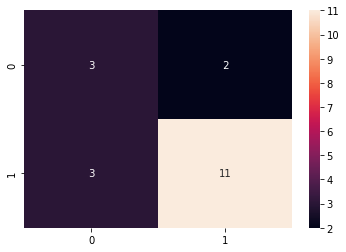

In [60]:
f1_test = f1_score(test_real, test_predict)
accuracy_test = accuracy_score(test_real, test_predict)
# print(f"f1: {f1_test:.4f}\naccuracy: {accuracy_test:.4f}")
print(classification_report(test_real, test_predict, digits=4))
print("---------------------------------------------------------")
sns.heatmap(confusion_matrix(test_real, test_predict),annot = True,fmt = '2.0f')
print()